In [23]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertModel
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [20]:
# enregistrer le modèle
def save_model(model, path="model/bert.pt"):
    torch.save(model.state_dict(), path)
    print(f"Modèle enregistré dans {path}")

In [18]:
# charger le modèle
def load_model(BERTClassifier, num_classes, path:str):
    model = BERTClassifier(num_classes=num_classes)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print(f"Modèle chargé depuis : {path}")
    return model

In [2]:
# Hyperparamètres
SEQ_LEN = 128
BATCH_SIZE = 32
EPOCHS = 4
PRETRAINED_MODEL = "camembert-base"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Charger le fichier de mappage
with open("label_mappings.json", "r", encoding="utf-8") as f:
    mappings = json.load(f)
label2Index = mappings["label2Index"]
index2label = {int(k): v for k, v in mappings["index2label"].items()}

In [4]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

In [5]:
# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained(PRETRAINED_MODEL)

In [6]:
# Dataset
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, seq_len):
        self.texts = df['text'].tolist()
        self.labels = df['labels'].tolist()
        self.seq_len = seq_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.seq_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    

In [7]:
# Créer Dataset et DataLoader
train_dataset = BERTDataset(df_train, tokenizer, SEQ_LEN)
val_dataset   = BERTDataset(df_val, tokenizer, SEQ_LEN)
test_dataset  = BERTDataset(df_test, tokenizer, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [8]:
# BERT + Dropout + Linear
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = CamembertModel.from_pretrained(PRETRAINED_MODEL)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Utiliser le vecteur du token [CLS]
        x = self.dropout(cls_output)
        logits = self.classifier(x)
        return logits

In [9]:
model = BERTClassifier(num_classes=len(label2Index)).to(DEVICE)

In [10]:
# Entrênement
def train(model, train_loader, val_loader, epochs, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(DEVICE)

    train_accs, val_accs = [], []  # Pour stocker les courbes

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            correct = (preds == labels).sum().item()

            total_loss += loss.item()
            total_correct += correct
            total += labels.size(0)

            loop.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Batch Acc": f"{correct / labels.size(0):.4f}"
            })

        # Entraînement terminé pour cette époque
        train_acc = total_correct / total
        train_accs.append(train_acc)

        # Évaluation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)

                outputs = model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1} Summary — Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_accs, val_accs

In [11]:
train_accs, val_accs = train(model, train_loader, val_loader, EPOCHS)

Epoch 1/4: 100%|█| 250/250 [24:37<00:00,  5.91s/it, Batch Loss=0.0947, Batch Acc


Epoch 1 Summary — Loss: 62.1368, Train Acc: 0.9044, Val Acc: 0.9790


Epoch 2/4: 100%|█| 250/250 [23:26<00:00,  5.62s/it, Batch Loss=0.0953, Batch Acc


Epoch 2 Summary — Loss: 33.2209, Train Acc: 0.9548, Val Acc: 0.9720


Epoch 3/4: 100%|█| 250/250 [23:42<00:00,  5.69s/it, Batch Loss=0.1105, Batch Acc


Epoch 3 Summary — Loss: 36.8837, Train Acc: 0.9355, Val Acc: 0.9870


Epoch 4/4: 100%|█| 250/250 [23:32<00:00,  5.65s/it, Batch Loss=0.0708, Batch Acc


Epoch 4 Summary — Loss: 29.2708, Train Acc: 0.9491, Val Acc: 0.9860


In [12]:
# plot
def plot_graph(train, val, title):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

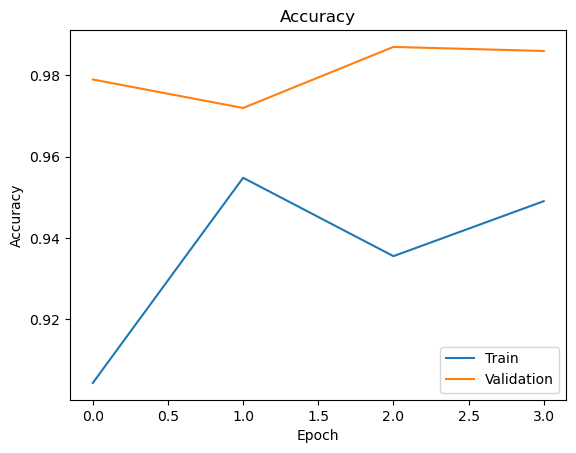

In [13]:
plot_graph(train_accs, val_accs, "Accuracy")

In [21]:
save_model(model)

Modèle enregistré dans model/bert.pt


In [26]:
# Évaluation
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Prédictions")
    plt.ylabel("Véritables")
    plt.tight_layout()
    plt.show()

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    
    # Mapper les indices aux noms des étiquettes
    y_true = [index2label[i] for i in y_true]
    y_pred = [index2label[i] for i in y_pred]
    labels = list(label2Index.keys()) 
    plot_confusion_matrix(y_true, y_pred, labels)
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    return y_true, y_pred

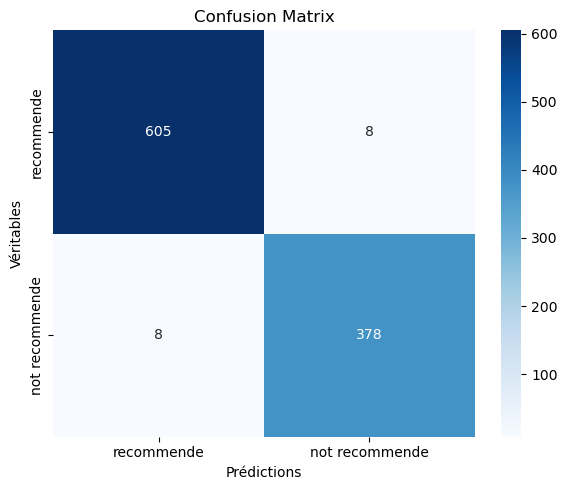


Classification Report:
                 precision    recall  f1-score   support

not recommende       0.98      0.98      0.98       386
    recommende       0.99      0.99      0.99       613

      accuracy                           0.98       999
     macro avg       0.98      0.98      0.98       999
  weighted avg       0.98      0.98      0.98       999



In [27]:
y_true, y_pred = evaluate(model, test_loader)